In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings('ignore')

from utils.wrangle import wrangle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('data/commodity_prices.csv')
df = wrangle(df)

df.describe(include='all')

,Product_Type,Arrival_Date,Market,Is_VFPCK,Season,Year,Modal_Price,Max_Price,Min_Price
count,167950,167950,167950,167950,167950,167950.000000,167950.000000,167950.000000,167950.000000
unique,124,NaN,28,2,4,NaN,NaN,NaN,NaN
top,Ashgourd|Ashgourd|FAQ,NaN,Perumbavoor,False,Southwest Monsoon,NaN,NaN,NaN,NaN
freq,5204,NaN,22135,142156,63908,NaN,NaN,NaN,NaN
mean,NaN,2024-08-08 15:45:00.932420608,NaN,NaN,NaN,2024.118410,5230.855469,5870.221911,4694.876885
min,NaN,2023-06-01 00:00:00,NaN,NaN,NaN,2023.000000,17.000000,0.000000,0.000000
25%,NaN,2024-02-03 00:00:00,NaN,NaN,NaN,2024.000000,3000.000000,3500.000000,2500.000000
50%,NaN,2024-08-19 00:00:00,NaN,NaN,NaN,2024.000000,4200.000000,5000.000000,3800.000000
75%,NaN,2025-02-23 00:00:00,NaN,NaN,NaN,2025.000000,5700.000000,6400.000000,5000.000000
max,NaN,2025-08-18 00:00:00,NaN,NaN,NaN,2025.000000,90000.000000,110000.000000,75000.000000


Seasonal Effect on Price

In [3]:
anova_results = {}

for product_type, group in df.groupby('Product_Type'):
    seasonal_groups = [seasonal_group['Modal_Price'].values for name, seasonal_group in group.groupby('Season')]

    if len(seasonal_groups) >= 2:
        stat, pval = f_oneway(*seasonal_groups)
        anova_results[product_type] = {'F-statistic': stat, 'p-value': pval}

# Convert to DataFrame for sorting/filtering
anova_df = pd.DataFrame(anova_results).T.reset_index().rename(columns={'index': 'Product_Type'})

anova_df = anova_df.sort_values(by='p-value', ascending=True).reset_index(drop=True)
anova_df.head(10)

,Product_Type,F-statistic,p-value
0,Drumstick|Drumstick|FAQ,791.160876,0.000000e+00
1,Onion|Big|FAQ,538.901744,1.540773e-281
2,Banana|Palayamthodan|Large,475.426745,2.272131e-259
3,Ashgourd|Ashgourd|FAQ,418.655413,1.301067e-243
4,Green Chilli|Green Chilly|FAQ,338.719053,1.558574e-192
5,Mango (Raw-Ripe)|Mango - Raw-Ripe|FAQ,341.879550,3.992625e-187
6,Banana|Nendra Bale|Large,296.851546,2.439530e-177
7,Bitter gourd|Bitter Gourd|FAQ,261.426468,3.069610e-155
8,Tomato|Tomato|FAQ,182.778703,2.791008e-107
9,Carrot|Carrot|FAQ,177.398630,6.891464e-107


Most commodities (>90%) show strong seasonal price variation.
High seasonal impact: Banana (Nendra Bale, Green), Ashgourd, Ginger (Green), Bitter Gourd, Drumstick, Onion (Big).
Low/no seasonal effect: Amaranthus, Cowpea (Bean Barbati), Papaya (Raw), Onion (1st Sort Non-FAQ).
Borderline: French Beans, Water Melon, Amaranthus (Other).
Seasonal swings align with crop perishability and harvest timing.

In [4]:
# Boolean flag: at least one record in VFPCK
vfpck_flag = (
    df.groupby('Product_Type')['Is_VFPCK']
      .any()
      .reset_index()
      .rename(columns={'Is_VFPCK': 'Has_VFPCK'})
)

# Fraction of records in VFPCK
vfpck_stats = (
    df.groupby('Product_Type')['Is_VFPCK']
      .mean()
      .reset_index()
      .rename(columns={'Is_VFPCK': 'Pct_VFPCK'})
)

# Merge both into ANOVA table
vfpck_df = anova_df.merge(vfpck_stats, on='Product_Type', how='left')
vfpck_df = vfpck_df.merge(vfpck_flag, on='Product_Type', how='left')

# Keep only products that have VFPCK presence
vfpck_df = vfpck_df[vfpck_df['Has_VFPCK'] == True]

# Sort if needed
vfpck_df = vfpck_df.sort_values('p-value').reset_index(drop=True)

# Display the final DataFrame
vfpck_df.head(10)

,Product_Type,F-statistic,p-value,Pct_VFPCK,Has_VFPCK
0,Banana|Palayamthodan|Large,475.426745,2.272131e-259,0.801531,True
1,Ashgourd|Ashgourd|FAQ,418.655413,1.301067e-243,0.261722,True
2,Green Chilli|Green Chilly|FAQ,338.719053,1.558574e-192,0.000585,True
3,Banana|Nendra Bale|Large,296.851546,2.439530e-177,0.865400,True
4,Bitter gourd|Bitter Gourd|FAQ,261.426468,3.069610e-155,0.092660,True
5,Banana|Poovan|Large,174.435406,1.027833e-103,0.799716,True
6,Lemon|Lemon|FAQ,172.082602,1.509685e-94,0.005140,True
7,Ginger(Green)|Green Ginger|FAQ,154.909699,1.843015e-93,0.033007,True
8,Amphophalus|Amphophalus|FAQ,132.069857,1.119217e-77,0.093404,True
9,Banana - Green|Banana - Green|FAQ,104.582119,1.915638e-65,0.218020,True


“VFPCK’s work has increased market access for farmers, but our analysis shows seasonal price swings remain high — even for commodities where VFPCK has significant market share.
Given the perishability of these crops, full-season storage is unrealistic. Instead, investments in value addition, short-term cold chain, market diversification, and forward contracting could better stabilize farmer incomes.”

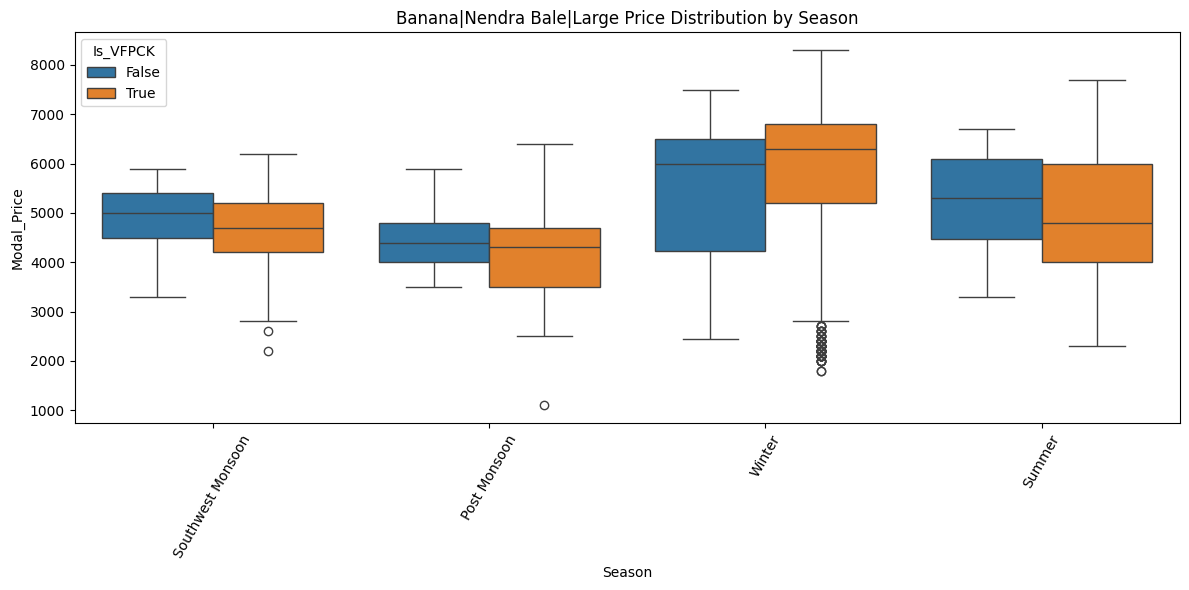

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df[df['Product_Type'] == 'Banana|Nendra Bale|Large'], x='Season', y='Modal_Price', hue='Is_VFPCK',ax=ax)
ax.set_title('Banana|Nendra Bale|Large Price Distribution by Season')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

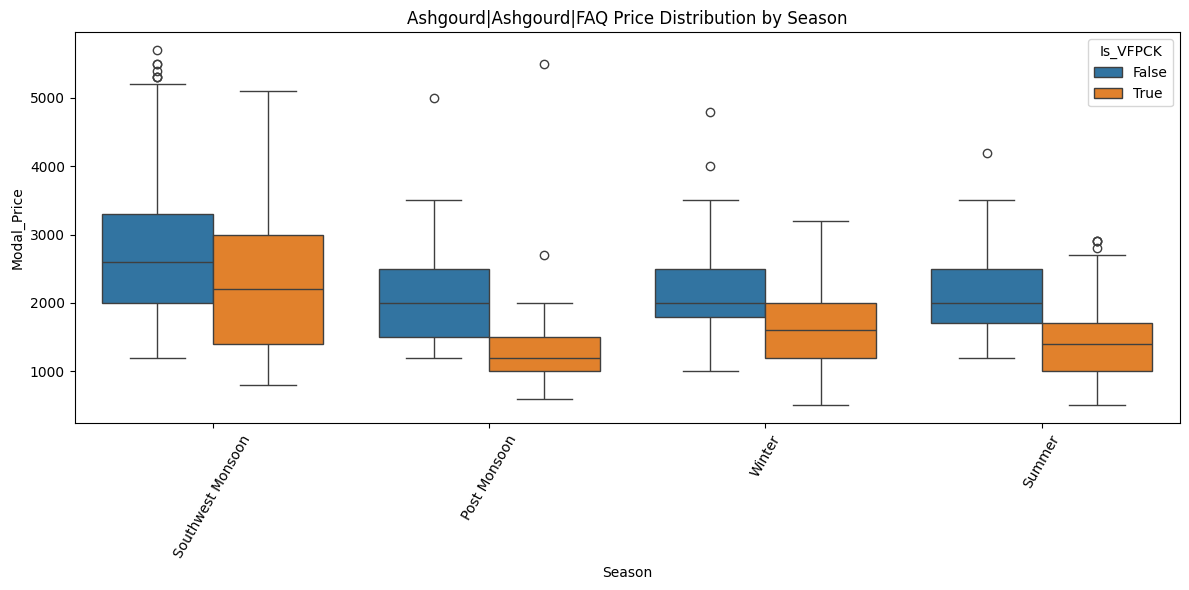

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df[df['Product_Type'] == 'Ashgourd|Ashgourd|FAQ'], x='Season', y='Modal_Price', hue='Is_VFPCK',ax=ax)
ax.set_title('Ashgourd|Ashgourd|FAQ Price Distribution by Season')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

In [ ]:
# 1. Calculate average price per product & season
seasonal_avg = (
    df.groupby(['Product_Type', 'Season'])['Modal_Price']
      .mean()
      .reset_index(name='Seasonal_avg_price')
)
# Get overall mean per product
overall_mean = (
    df.groupby('Product_Type')['Modal_Price']
      .mean()
      .reset_index()
      .rename(columns={'Modal_Price': 'Overall_Mean'})
)

# Merge overall mean into seasonal averages
seasonal_avg = seasonal_avg.merge(overall_mean, on='Product_Type')

# Calculate seasonal index
seasonal_avg['Seasonal_Index'] = (
    seasonal_avg['Seasonal_avg_price'] / seasonal_avg['Overall_Mean']
)

seasonal_avg.head(10)

,Product_Type,Season,Seasonal_avg_price,Overall_Mean,Seasonal_Index
0,Alsandikai|Alsandikai|FAQ,Post Monsoon,4239.583333,4302.123142,0.985463
1,Alsandikai|Alsandikai|FAQ,Southwest Monsoon,4732.666667,4302.123142,1.100077
2,Alsandikai|Alsandikai|FAQ,Summer,3620.422535,4302.123142,0.841543
3,Alsandikai|Alsandikai|FAQ,Winter,4570.992366,4302.123142,1.062497
4,Amaranthus|Amaranthus|FAQ,Post Monsoon,3415.929204,3307.963488,1.032638
5,Amaranthus|Amaranthus|FAQ,Southwest Monsoon,3294.165946,3307.963488,0.995829
6,Amaranthus|Amaranthus|FAQ,Summer,3236.073620,3307.963488,0.978268
7,Amaranthus|Amaranthus|FAQ,Winter,3342.164675,3307.963488,1.010339
8,Amaranthus|Other|FAQ,Post Monsoon,3719.444444,4015.775862,0.926208
9,Amaranthus|Other|FAQ,Southwest Monsoon,3898.917749,4015.775862,0.970900


In [ ]:
results = []
for (prod, market, season), group in df.groupby(['Product_Type', 'Market', 'Season']):
    if group['Year'].nunique() > 1:  # need at least 2 years
        samples = [grp['Modal_Price'].values for _, grp in group.groupby('Year')]
        stat, p = f_oneway(*samples)
        results.append({
            'Product': prod,
            'Market': market,
            'Season': season,
            'F_stat': stat,
            'p_value': p
        })

results_df = pd.DataFrame(results)
results_df['reject'], results_df['p_adj'], _, _ = multipletests(
    results_df['p_value'], method='fdr_bh'
)

results_df['reject'].value_counts(normalize=True)


In [8]:
model = smf.mixedlm('Modal_Price ~ C(Market) + C(Product_Type)', 
                data=df, 
                groups=df['Arrival_Date'])
result = model.fit()

print(result.summary())

                                           Mixed Linear Model Regression Results
Model:                                   MixedLM                      Dependent Variable:                      Modal_Price  
No. Observations:                        167950                       Method:                                  REML         
No. Groups:                              805                          Scale:                                   3857768.7000 
Min. group size:                         10                           Log-Likelihood:                          -1511821.8839
Max. group size:                         318                          Converged:                               Yes          
Mean group size:                         208.6                                                                              
----------------------------------------------------------------------------------------------------------------------------
                                            

**Observation:**  
Mixed-effects model results show clear, consistent price differences between markets, even after controlling for product type and arrival date.  
This suggests that market-level factors (e.g., supply chain, demand patterns, VFPCK vs. non-VFPCK operations) play a significant role in price variation.  
These coefficients provide a baseline-adjusted measure of each market’s typical pricing, which we will use to rank markets by relative price levels.

In [ ]:
# Get market ranking
fe_params = result.fe_params
market_ranking = fe_params.filter(like='C(Market)')
market_ranking.index = market_ranking.index.str.replace('C(Market)[T.', '').str.replace(']', '')
market_ranking['Aluva'] = 0  # Add Aluva as baseline
market_ranking.sort_values(ascending=True, inplace=True)
print(market_ranking)

Vengola  VFPCK           -1041.035913
KURUMASSERY VFPCK         -861.474232
Keezhampara VFPCK         -792.091869
Edackattuvayal  VFPCK     -785.942876
Mazhuvannur VFPCK         -686.741504
Perumbavoor               -626.899462
Mookkannur  VFPCK         -511.063680
Koovapadi VFPCK           -471.234679
Thiruvaniyoor  VFPCK      -467.884995
Moovattupuzha             -442.756169
Nedungapra  VFPCK         -380.591409
POTHANIKKADU VFPCK        -352.575408
Amalapuram  VFPCK         -231.688027
Kothamangalam             -183.228305
KARUMALOOR VFPCK          -167.823415
THURAVOOR VFPCK           -144.053081
Kunnukara  VFPCK           -53.132397
Ernakulam                  -39.129267
KANJOOR VFPCK              -25.933307
Malayattoor  VFPCK         -15.232830
Aluva                        0.000000
Kadungallur  VFPCK         199.371197
North Paravur              638.349604
Angamaly                   661.198808
Broadway market            762.121394
Puthenvelikkara  VFPCK     773.116487
Piravam     

We observe that most VFPCK markets tend to offer lower prices compared to non-VFPCK markets.  
Earlier seasonal analysis showed that VFPCK prices also fluctuate with seasonality.  
From a consumer’s perspective, these lower prices are beneficial, but for farmers, they may reduce profit margins.  

Higher prices in urban or semi-urban markets like Angamaly and Ernakulam could be driven by stronger demand and higher willingness to pay, possibly amplified by transportation and logistics costs.  
However, to draw a stronger conclusion, we would need to map each market’s location, classify them as urban/rural, and examine their surrounding population and demand patterns.

In [10]:
df.groupby('Product_Type')['Market'].nunique().sort_values(ascending=False)

Product_Type
Banana|Palayamthodan|Large                             19
Banana|Nendra Bale|Large                               17
Banana|Poovan|Large                                    16
Banana|Palayamthodan|Medium                            16
Banana|Poovan|Medium                                   15
Ashgourd|Ashgourd|FAQ                                  15
Cowpea(Veg)|Cowpea (Veg)|FAQ                           14
Banana|Robusta|Large                                   12
Bitter gourd|Bitter Gourd|FAQ                          12
Cucumbar(Kheera)|Cucumbar|FAQ                          12
Banana - Green|Banana - Green|FAQ                      12
Bhindi(Ladies Finger)|Bhindi|FAQ                       11
Banana|Nendra Bale|Medium                              10
Tapioca|Tapioca|FAQ                                    10
Ginger(Green)|Green Ginger|FAQ                         10
Pineapple|Other|Large                                   9
Tapioca|Other|FAQ                                       9
G

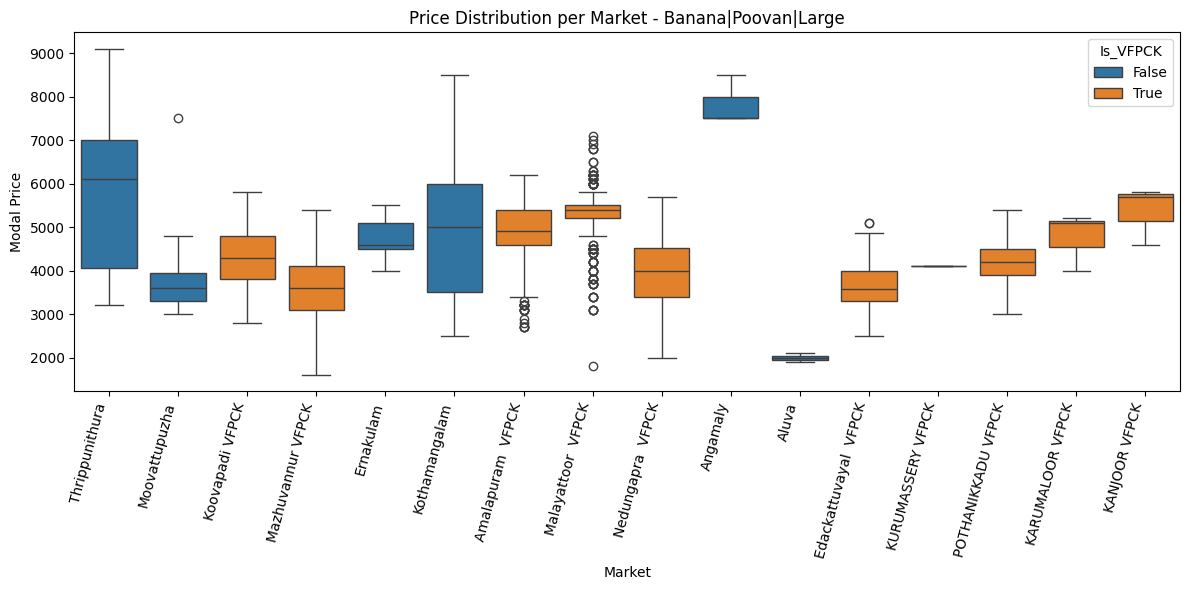

In [11]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[df['Product_Type'] == 'Banana|Poovan|Large'], x='Market', y='Modal_Price', hue='Is_VFPCK')

plt.xticks(rotation=75, ha='right')
plt.title(f"Price Distribution per Market - Banana|Poovan|Large")
plt.ylabel("Modal Price")
plt.xlabel("Market")
plt.tight_layout()
plt.show()

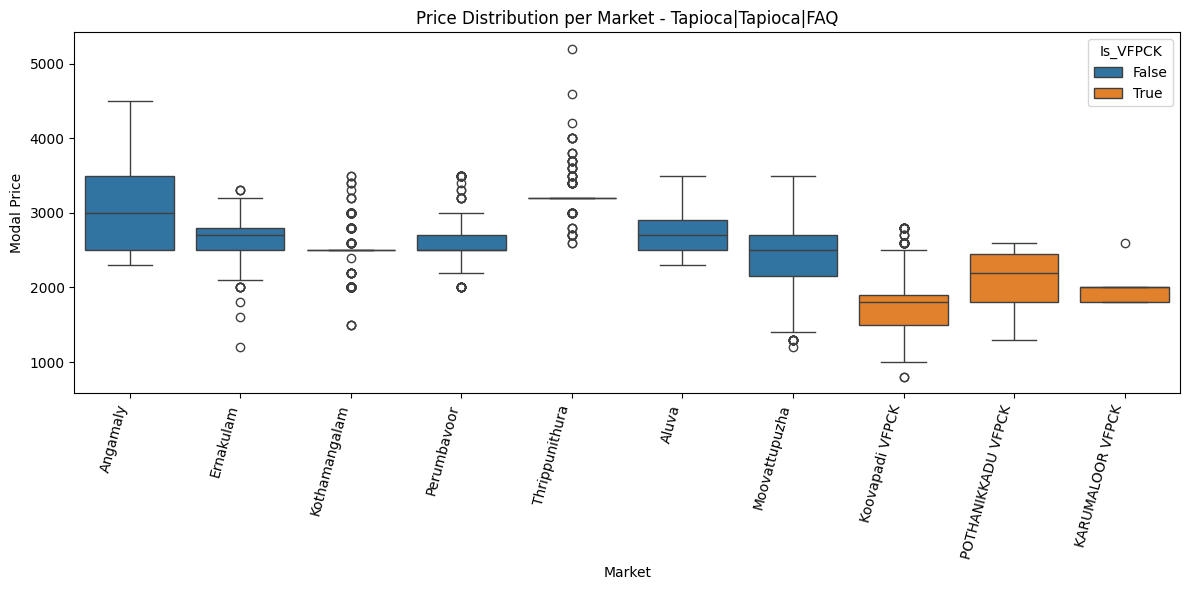

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[df['Product_Type'] == 'Tapioca|Tapioca|FAQ'], x='Market', y='Modal_Price', hue='Is_VFPCK')

plt.xticks(rotation=75, ha='right')
plt.title(f"Price Distribution per Market - Tapioca|Tapioca|FAQ")
plt.ylabel("Modal Price")
plt.xlabel("Market")
plt.tight_layout()
plt.show()